This is an adaptation of the [Holt-Winters with Python](https://docs.timescale.com/latest/tutorials/tutorial-forecasting#tutorial-python) example for TimescaleDB using the [Prometheus SQL adapter](https://github.com/ssube/prometheus-sql-adapter) schema as a data source.

In [101]:
import matplotlib.pyplot as plot
import pandas as pd
import pandas.io.json as pj
import psycopg2
import os

In [102]:
conn = psycopg2.connect(os.environ.get('PROMSQL_CONNSTR'))
samples = pd.read_sql_query("""
SELECT 
    s.bucket AS time, 
    MAX(s.max_load) AS value, 
    REGEXP_REPLACE(l.labels->>'instance', '\d+\.\d+\.\d+\.', 'xxx.yyy.zzz.') AS instance 
FROM agg_instance_load AS s
JOIN metric_labels AS l 
    ON s.lid = l.lid
WHERE s.bucket > NOW() - INTERVAL '7 days'
GROUP BY s.bucket, l.labels->>'instance'
""", conn)
conn.close()

In [103]:
print(samples.head(5))

                 time  value              instance
0 2019-12-19 13:45:00  15.17   xxx.yyy.zzz.59:9100
1 2019-12-21 05:55:00   1.54  xxx.yyy.zzz.163:9100
2 2019-12-15 22:50:00   0.66   xxx.yyy.zzz.59:9100
3 2019-12-18 05:05:00   0.86  xxx.yyy.zzz.158:9100
4 2019-12-17 04:10:00   1.68  xxx.yyy.zzz.163:9100


In [104]:
nodes = samples[['instance']].replace(r':\d+', '', regex=True)
load = samples.drop(columns=['instance']).join(nodes)

              instance
0       xxx.yyy.zzz.59
1      xxx.yyy.zzz.163
2       xxx.yyy.zzz.59
3      xxx.yyy.zzz.158
4      xxx.yyy.zzz.163
...                ...
18112  xxx.yyy.zzz.180
18113  xxx.yyy.zzz.158
18114  xxx.yyy.zzz.163
18115  xxx.yyy.zzz.158
18116  xxx.yyy.zzz.192

[18117 rows x 1 columns]


In [105]:
print(load.head(15))

                  time  value         instance
0  2019-12-19 13:45:00  15.17   xxx.yyy.zzz.59
1  2019-12-21 05:55:00   1.54  xxx.yyy.zzz.163
2  2019-12-15 22:50:00   0.66   xxx.yyy.zzz.59
3  2019-12-18 05:05:00   0.86  xxx.yyy.zzz.158
4  2019-12-17 04:10:00   1.68  xxx.yyy.zzz.163
5  2019-12-19 05:40:00   0.86  xxx.yyy.zzz.192
6  2019-12-17 15:55:00   1.61  xxx.yyy.zzz.192
7  2019-12-16 04:20:00   1.02  xxx.yyy.zzz.180
8  2019-12-17 11:50:00   0.94  xxx.yyy.zzz.163
9  2019-12-17 03:25:00   1.11  xxx.yyy.zzz.164
10 2019-12-18 18:50:00   0.37  xxx.yyy.zzz.158
11 2019-12-20 02:00:00   0.67  xxx.yyy.zzz.164
12 2019-12-19 03:05:00   0.94  xxx.yyy.zzz.236
13 2019-12-20 23:25:00   0.41  xxx.yyy.zzz.192
14 2019-12-22 11:55:00   0.32  xxx.yyy.zzz.158


In [106]:
iload = load.groupby(['instance'])
print(iload.describe())

                  value                                                   
                  count      mean       std   min   25%   50%   75%    max
instance                                                                  
xxx.yyy.zzz.158  2013.0  0.402350  0.263008  0.02  0.22  0.33  0.52   2.27
xxx.yyy.zzz.163  2013.0  1.549329  0.612888  0.31  1.07  1.47  1.93   4.31
xxx.yyy.zzz.164  2013.0  0.846110  0.428315  0.13  0.54  0.76  1.04   2.85
xxx.yyy.zzz.180  2013.0  1.060283  0.815511  0.15  0.59  0.88  1.26  10.00
xxx.yyy.zzz.192  2013.0  0.825708  0.400223  0.10  0.52  0.76  1.08   2.54
xxx.yyy.zzz.236  2013.0  0.549146  0.259378  0.10  0.37  0.48  0.67   2.23
xxx.yyy.zzz.59   2013.0  1.232881  1.892115  0.08  0.45  0.68  1.07  15.17
xxx.yyy.zzz.77   2013.0  0.893716  0.457927  0.07  0.59  0.84  1.11   7.34
xxx.yyy.zzz.99   2013.0  0.837914  0.446957  0.09  0.54  0.73  1.01   3.11


In [107]:
tload = pd.pivot(load, index='time', columns='instance', values='value').resample('1h').max()
print(tload.head(2))

instance             xxx.yyy.zzz.158  xxx.yyy.zzz.163  xxx.yyy.zzz.164  \
time                                                                     
2019-12-15 22:00:00             0.60             2.12             2.49   
2019-12-15 23:00:00             0.95             2.11             0.93   

instance             xxx.yyy.zzz.180  xxx.yyy.zzz.192  xxx.yyy.zzz.236  \
time                                                                     
2019-12-15 22:00:00             2.22             1.28             1.04   
2019-12-15 23:00:00             1.90             1.84             1.11   

instance             xxx.yyy.zzz.59  xxx.yyy.zzz.77  xxx.yyy.zzz.99  
time                                                                 
2019-12-15 22:00:00            0.82            1.44            2.20  
2019-12-15 23:00:00            0.88            1.65            0.94  


Fitting trends for xxx.yyy.zzz.158
Fitting trends for xxx.yyy.zzz.163
Fitting trends for xxx.yyy.zzz.164
Fitting trends for xxx.yyy.zzz.180
Fitting trends for xxx.yyy.zzz.192
Fitting trends for xxx.yyy.zzz.236
Fitting trends for xxx.yyy.zzz.59
Fitting trends for xxx.yyy.zzz.77
Fitting trends for xxx.yyy.zzz.99


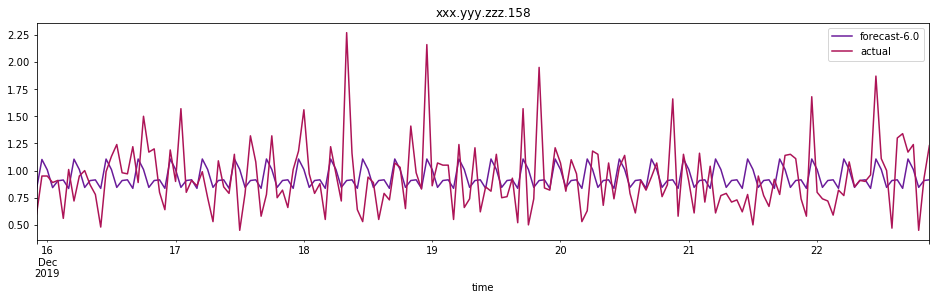

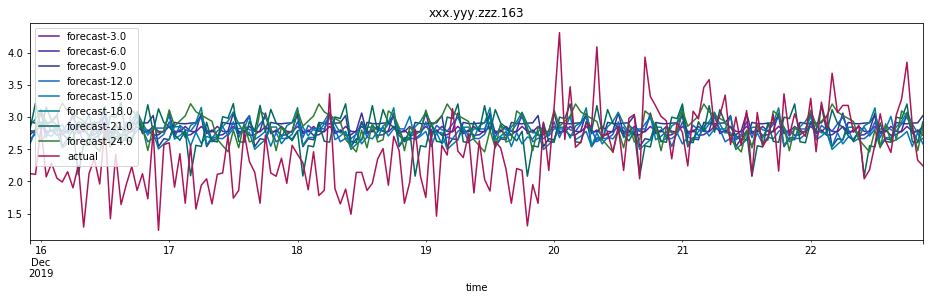

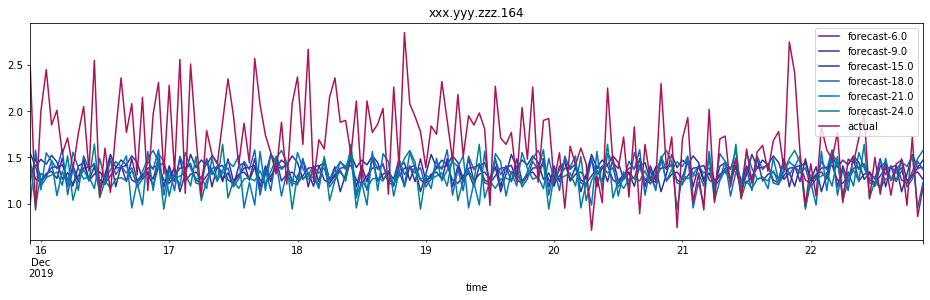

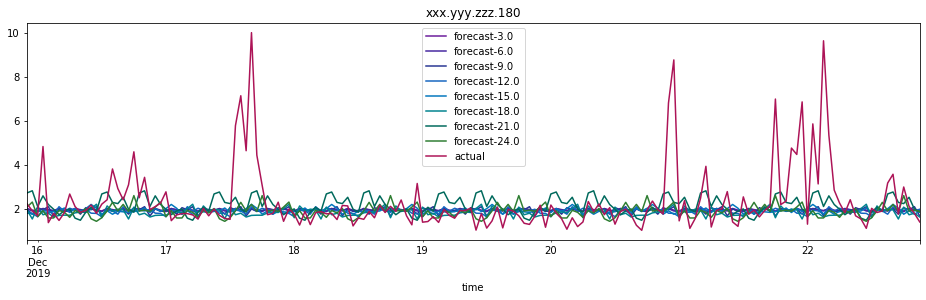

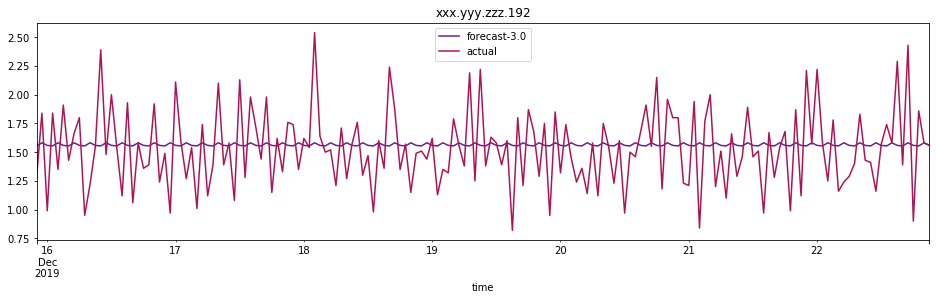

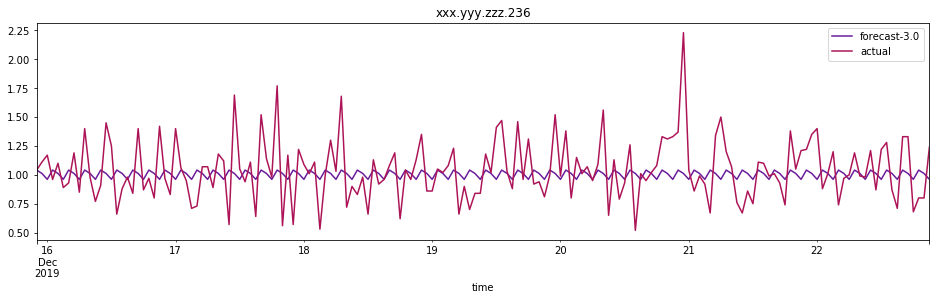

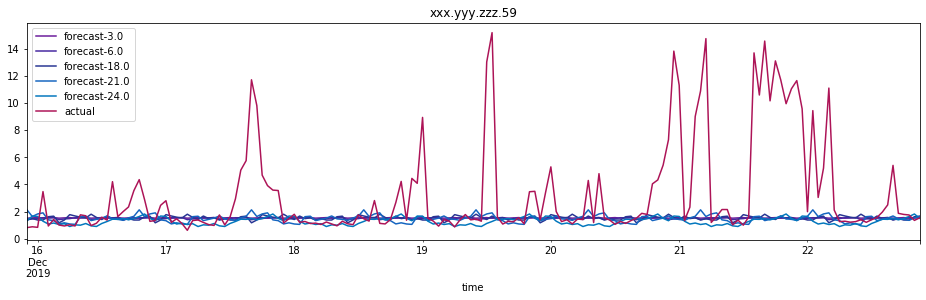

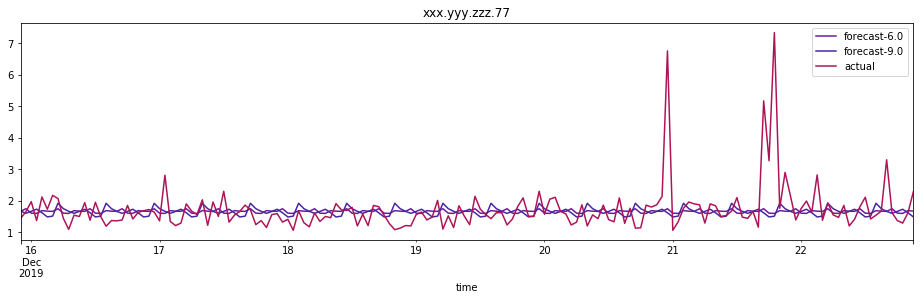

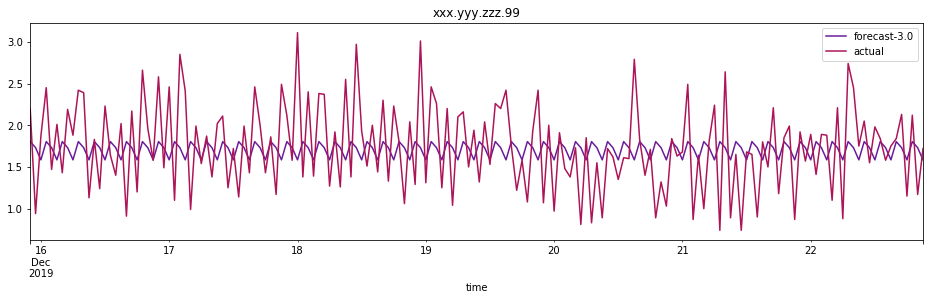

In [109]:
%matplotlib inline
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

palette_fit = [
    '#6a1b9a', '#4527a0', '#283593', '#1565c0',
    '#0277bd', '#00838f', '#00695c', '#2e7d32'
]
palette_key = '#ad1457'

period_hour = 3
period_num = 8

tf = pd.DataFrame(data=tload, copy=True)
for row in tf:
    fload = tf[row]
    vals = np.array(fload.to_numpy(np.float64).flat)
    
    print(f'Fitting trends for {fload.name}')
    fss = []
    for period in np.linspace(period_hour, period_hour * period_num, period_num):
        try:
            fit = ExponentialSmoothing(
                vals, trend='add', seasonal='add', seasonal_periods=int(period), damped=True
            ).fit(use_boxcox=True)
            forecast = fit.forecast(len(fload))
            
            if not np.isnan(forecast[0]):
                fs = pd.Series(forecast, name=f'forecast-{period}', index=fload.index)
                fss.append(fs)
        except:
            print(f'error fitting {row} at {period} hour period')
    
    colors = palette_fit[0:len(fss)]
    colors.append(palette_key)
    
    overall = pd.concat([*fss, fload], axis=1).rename(columns={fload.name: "actual"})    
    overall.plot.line(title=fload.name, color=colors, figsize=(16, 4))